# [HT]面談率予測モデル構築に向けた事前分析
+ 2018/08/16
+ マーケティング部データアナリスト 阪上晃幸

## 方針
+ 重複レコードの確認
+ データの作成  
・年齢  
・エリア  
・受注フラグ　　
+ クロス集計（様々な軸と面談率の関係）
+ 可視化（時系列での変容があるか、ヒストグラムはどのような形状か）  
・受注金額のヒストグラム
+ よくあるアルゴリズムの適用

In [150]:
%matplotlib inline
import pandas as pd
import numpy as np

pd.set_option('max_columns',40)

#関東フラグ作成用データ
kanto_pref = [8,9,10,11,12,13,14]

listing_inflow_data = pd.read_csv("data.csv")

listing_inflow_data["age"] = list(map(lambda record: 2018 - int(str(record)[0:4]) , listing_inflow_data.birth))
listing_inflow_data["sales_flag"] = np.where(listing_inflow_data.sales.isna(), 0, 1)
listing_inflow_data["kanto_flag"] = np.where(listing_inflow_data.prefecture.isin(kanto_pref), 1, 0)

listing_inflow_data["entry_month"] =  pd.to_datetime(listing_inflow_data.entry_date)
listing_inflow_data["entry_month"] = np.where(listing_inflow_data["entry_month"].dt.day == 1,
                                                                                    listing_inflow_data["entry_month"].dt.floor('d'),
                                                                                    listing_inflow_data["entry_month"].dt.floor('d') - pd.offsets.MonthBegin(1))

duplicated_ids = list(pd.DataFrame(listing_inflow_data.employee_id.value_counts()).reset_index().query(' employee_id > 1')["index"])
listing_inflow_data["duplicated_flag"] = np.where(listing_inflow_data.employee_id.isin(duplicated_ids ), 1, 0)

listing_inflow_data.tail(3)

,employee_id,entry_date,sex,birth,prefecture,status,career_change_desired_date,graduation_year,device,influx_route_big,influx_route_midium,influx_route_small,register_type,counseling_flag,sales,sales_date,age,sales_flag,kanto_flag,entry_month,duplicated_flag
8781,235582,2018-08-07 23:46:29,1,19941231,12,正社員,3ヶ月以上先,2016,SP,リスティング,Google検索,指名検索軸,2,0,NaN,NaN,24,0,1,2018-08-01,0
8782,235587,2018-08-07 23:52:03,1,19911231,11,離職中・フリーター\n (契約・派遣含む),できるだけ早く,2010,SP,リスティング,Google検索,こだわり軸,2,0,NaN,NaN,27,0,1,2018-08-01,0
8783,235588,2018-08-07 23:52:40,2,19951231,27,離職中・フリーター\n (契約・派遣含む),できるだけ早く,2013,PC,リスティング,Google検索,支援軸,3,0,NaN,NaN,23,0,0,2018-08-01,0


In [151]:
print("employee_idのカウント："+str(len(listing_inflow_data)))
print("ユニークemployee_idのカウント："+str(listing_inflow_data.employee_id.unique().size))

employee_idのカウント：8784
ユニークemployee_idのカウント：7771


In [152]:
(listing_inflow_data.employee_id.value_counts() > 1).value_counts()

False    7010
True      761
Name: employee_id, dtype: int64

761件ほど重複したレコードがある模様。

register_typeのマスター  

0: リード仮登録                 
1: 仮登録
2: アプローチ               
3: 面談待ち
4: 面談済み                
7: 自社決
8: 他社決                   
9: 退会
10: 年齢NG                
11: 条件NG
12: 面談日程連絡待ち   
13: 無断キャンセル
14: 掘り起こし
15: 学生NG                
16: 経歴NG
17: 勤務地NG             
18: 経歴待ちステータス
19: 情報不備              

性別

In [186]:
listing_inflow_data.groupby('sex')['counseling_flag'].agg(["count",np.sum, np.mean])

,count,sum,mean
sex,,,
1,4612,1279,0.27732
2,4172,880,0.21093


関東かどうか

In [153]:
listing_inflow_data.groupby('kanto_flag')['counseling_flag'].agg(["count",np.sum, np.mean])

,count,sum,mean
kanto_flag,,,
0,919,95,0.103373
1,7865,2064,0.262428


関東の方が16%ポイントほど面談率が高い。

ステータスごとの傾向

In [154]:
listing_inflow_data.groupby('status')['counseling_flag'].agg(["count",np.sum, np.mean])

,count,sum,mean
status,,,
在学中\n（中退を検討中）,211,23,0.109005
在学中\n（中退予定）,408,96,0.235294
在学中\n（卒業予定）,1017,79,0.077679
正社員,2451,446,0.181967
離職中・フリーター\n (契約・派遣含む),4622,1492,0.322804


+ 卒業予定は面談率が低い
+ 離職中は面談率が高い

希望転職時期ごとの傾向

In [155]:
listing_inflow_data.groupby('career_change_desired_date')['counseling_flag'].agg(["count",np.sum, np.mean])

,count,sum,mean
career_change_desired_date,,,
1～2ヶ月先,1765,511,0.289518
3ヶ月以上先,1233,203,0.164639
できるだけ早く,4646,1243,0.267542
まだ本当に活動するか決めていない,1065,179,0.168075


「3ヶ月以上先」と「まだ本当に活動するか決めていない」は同じくらい  
「1～2ヶ月先」と「できるだけ早く」は同じくらい

デバイスごとの傾向

In [156]:
listing_inflow_data.groupby('device')['counseling_flag'].agg(["count",np.sum, np.mean])

,count,sum,mean
device,,,
PC,795,289,0.363522
SP,7989,1870,0.234072


PCの方が面談率が高い

流入経路ごとの傾向

In [157]:
listing_inflow_data.groupby('influx_route_midium')['counseling_flag'].agg(["count",np.sum, np.mean])

,count,sum,mean
influx_route_midium,,,
Google検索,7540,1903,0.252387
Yahoo検索,1244,256,0.205788


Yahoo!ユーザーは面談率が低い

流入経路のキャンペーンごとの傾向

In [158]:
listing_inflow_data.groupby('influx_route_small')['counseling_flag'].agg(["count",np.sum, np.mean]).sort_values(by="count", ascending=False).head(8)

,count,sum,mean
influx_route_small,,,
ハローワーク軸,2957,531,0.179574
属性軸_高卒軸,1374,164,0.119360
属性軸_フリーター軸,1282,363,0.283151
指名検索軸,1245,680,0.546185
就職軸_学歴KW軸,548,114,0.208029
正社員軸,250,43,0.172000
転職軸,183,73,0.398907
こだわり軸,165,14,0.084848


+ 指名検索軸は面談率が高い
+ 属性軸_高卒軸は面談率が低い

年齢と面談率の関係

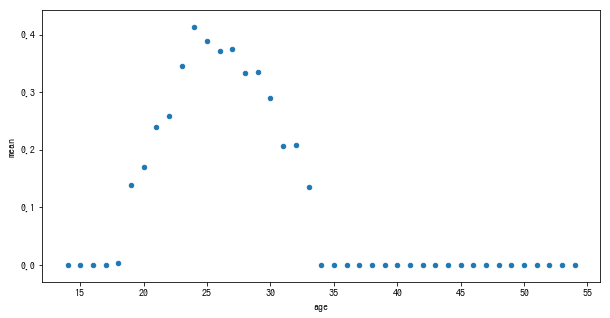

In [159]:
listing_inflow_data.groupby('age')['counseling_flag'].agg([np.mean]).reset_index().plot(kind="scatter",x="age", y="mean",figsize=(10,5))

年齢と面談率は非線形の関係が観察されている。

In [198]:
bins = [0,20,23,25,30,35,100]
labels=["~20","21~22","23~25","26~30","31~35", "36~"]
listing_inflow_data['age_bins'] = pd.cut(listing_inflow_data['age'], bins=bins, labels=labels, include_lowest=True)
listing_inflow_data.groupby('age_bins')['counseling_flag'].agg(["count",np.sum, np.mean])

,count,sum,mean
age_bins,,,
~20,1974,204,0.103343
21~22,2531,711,0.280917
23~25,1460,588,0.402740
26~30,1699,591,0.347852
31~35,543,65,0.119705
36~,577,0,0.000000


売上のヒストグラム

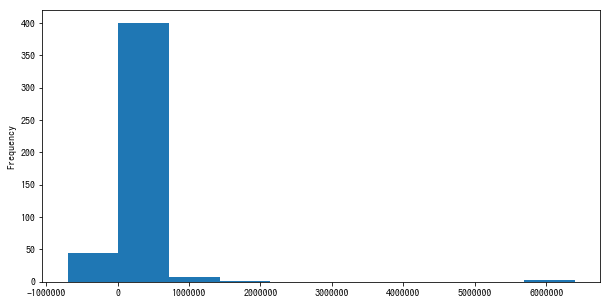

In [180]:
listing_inflow_data.query(' sales_flag > 0 ').sales.plot.hist(figsize=(10,5))

売上が600万円近いものがある。これはおかしそう。

In [182]:
listing_inflow_data.query(' sales_flag > 0 ').sales.describe()

count    4.560000e+02
mean     4.245277e+05
std      5.456638e+05
min     -7.000000e+05
25%      3.000000e+05
50%      4.500000e+05
75%      5.000000e+05
max      6.400000e+06
Name: sales, dtype: float64

In [161]:
listing_inflow_data.query(' sales > 3000000 ')

,employee_id,entry_date,sex,birth,prefecture,status,career_change_desired_date,graduation_year,device,influx_route_big,influx_route_midium,influx_route_small,register_type,counseling_flag,sales,sales_date,age,sales_flag,kanto_flag,entry_month,duplicated_flag
3654,210140,2018-05-23 11:15:25,1,19951231,13,離職中・フリーター\n (契約・派遣含む),できるだけ早く,2017,PC,リスティング,Google検索,指名検索軸,4,1,6400000.0,2018-07-11 19:58:58,23,1,1,2018-05-01,1
3656,210140,2018-05-23 11:15:25,1,19951231,13,離職中・フリーター\n (契約・派遣含む),できるだけ早く,2017,PC,リスティング,Google検索,指名検索軸,4,1,6400000.0,2018-07-11 19:58:08,23,1,1,2018-05-01,1
3657,210140,2018-05-23 11:15:25,1,19951231,13,離職中・フリーター\n (契約・派遣含む),できるだけ早く,2017,PC,リスティング,Google検索,指名検索軸,4,1,6400000.0,2018-07-11 19:57:33,23,1,1,2018-05-01,1


jupyter nbconvert --to slides "/Users/sakaue/PythonScripts/HC/Listing/HC_Listing_Interview_Analysis.ipynb" --post servem

array([<matplotlib.axes._subplots.AxesSubplot object at 0x119cbdeb8>,
      dtype=object)

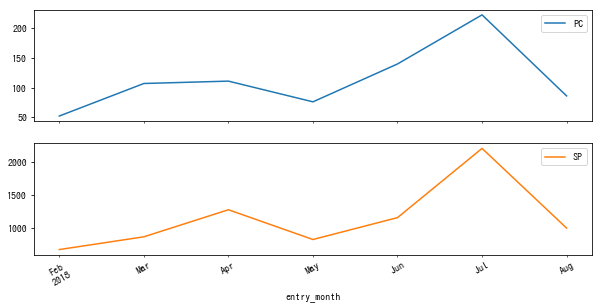

In [162]:
pd.DataFrame(pd.pivot_table(data=listing_inflow_data , fill_value=0, index="device", columns="entry_month",aggfunc = {  'entry_month' : 'count' } ).transpose().to_records()).iloc[:, 1:].plot(subplots=True,x="entry_month",figsize=(10,5))

array([<matplotlib.axes._subplots.AxesSubplot object at 0x119e2c940>,
      dtype=object)

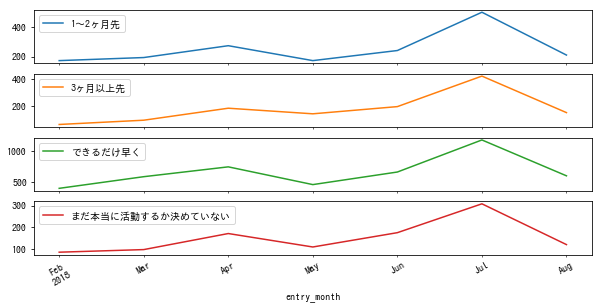

In [163]:
pd.DataFrame(pd.pivot_table(data=listing_inflow_data , fill_value=0, index="career_change_desired_date", columns="entry_month",aggfunc = {  'entry_month' : 'count' } ).transpose().to_records()).iloc[:, 1:].plot(subplots=True,x="entry_month",figsize=(10,5))

array([<matplotlib.axes._subplots.AxesSubplot object at 0x11a047cf8>,
      dtype=object)

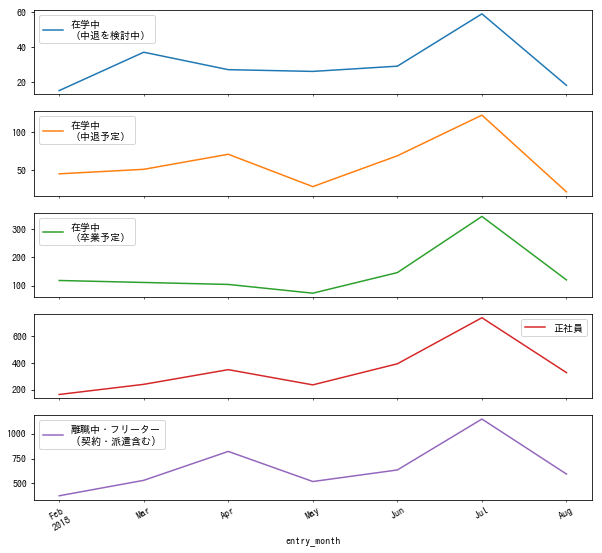

In [164]:
pd.DataFrame(pd.pivot_table(data=listing_inflow_data , fill_value=0, index="status", columns="entry_month",aggfunc = {  'entry_month' : 'count' } ).transpose().to_records()).iloc[:, 1:].plot(subplots=True,x="entry_month",figsize=(10,10))

array([<matplotlib.axes._subplots.AxesSubplot object at 0x11a296fd0>,
      dtype=object)

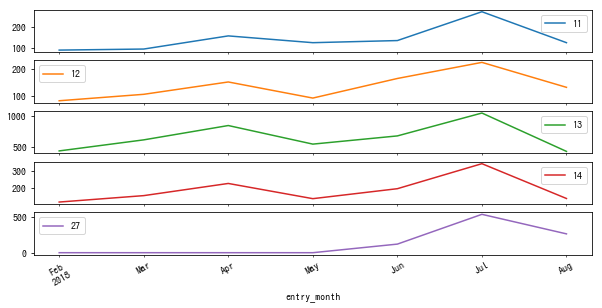

In [165]:
pd.DataFrame(pd.pivot_table(data=listing_inflow_data , fill_value=0, index="prefecture", columns="entry_month",aggfunc = {  'entry_month' : 'count' } ).transpose().to_records()).iloc[:, 1:].plot(subplots=True,x="entry_month",figsize=(10,5))

array([<matplotlib.axes._subplots.AxesSubplot object at 0x11a5bd1d0>],
      dtype=object)

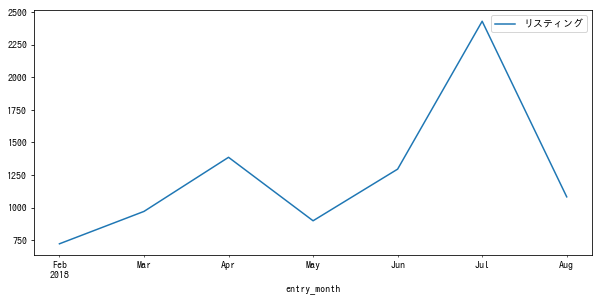

In [166]:
pd.DataFrame(pd.pivot_table(data=listing_inflow_data , fill_value=0, index="influx_route_big", columns="entry_month",aggfunc = {  'entry_month' : 'count' } ).transpose().to_records()).iloc[:, 1:].plot(subplots=True,x="entry_month",figsize=(10,5))

array([<matplotlib.axes._subplots.AxesSubplot object at 0x11a6da198>,
      dtype=object)

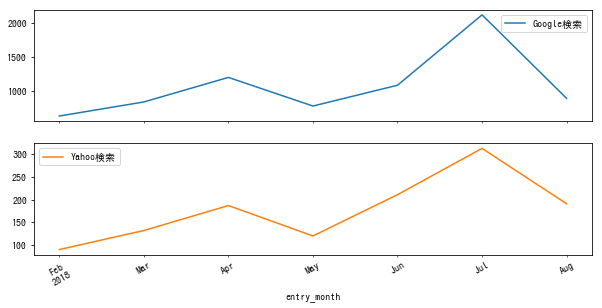

In [167]:
pd.DataFrame(pd.pivot_table(data=listing_inflow_data , fill_value=0, index="influx_route_midium", columns="entry_month",aggfunc = {  'entry_month' : 'count' } ).transpose().to_records()).iloc[:, 1:].plot(subplots=True,x="entry_month",figsize=(10,5))

array([<matplotlib.axes._subplots.AxesSubplot object at 0x11a8220f0>,
      dtype=object)

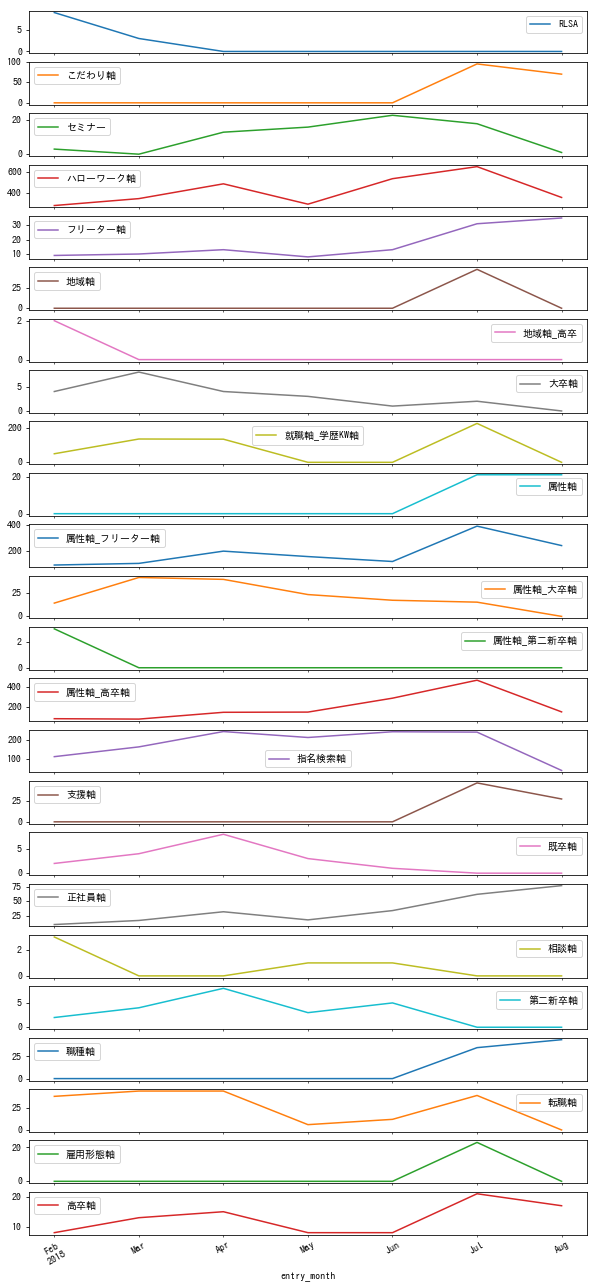

In [168]:
pd.DataFrame(pd.pivot_table(data=listing_inflow_data , fill_value=0, index="influx_route_small", columns="entry_month",aggfunc = {  'entry_month' : 'count' } ).transpose().to_records()).iloc[:, 1:].plot(subplots=True,x="entry_month",figsize=(10,25))

array([<matplotlib.axes._subplots.AxesSubplot object at 0x11b0a86a0>,
      dtype=object)

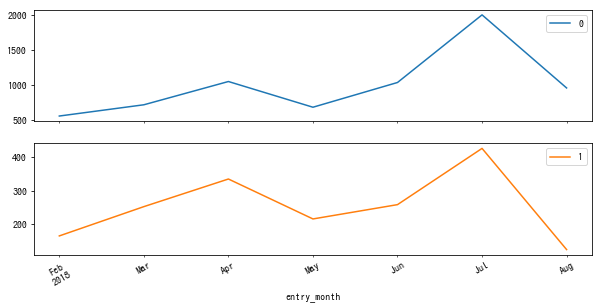

In [169]:
pd.DataFrame(pd.pivot_table(data=listing_inflow_data , fill_value=0, index="duplicated_flag", columns="entry_month",aggfunc = {  'entry_month' : 'count' } ).transpose().to_records()).iloc[:, 1:].plot(subplots=True,x="entry_month",figsize=(10,5))

重複フラグの発生は一定の割合で発生している模様。

重複ユーザーを除外して分析進めていく。

In [200]:
train_dataset = listing_inflow_data[listing_inflow_data.duplicated_flag == 0].reset_index(drop=True)
train_dataset.head(3)

,employee_id,entry_date,sex,birth,prefecture,status,career_change_desired_date,graduation_year,device,influx_route_big,influx_route_midium,influx_route_small,register_type,counseling_flag,sales,sales_date,age,sales_flag,kanto_flag,entry_month,duplicated_flag,age_bins
0,133168,2018-02-09 0:00:56,1,19961231,12,離職中・フリーター\n (契約・派遣含む),3ヶ月以上先,2016年以前,SP,リスティング,Google検索,属性軸_大卒軸,4,1,NaN,NaN,22,0,1,2018-02-01,0,21~22
1,133188,2018-02-09 1:23:10,2,19901231,13,在学中\n（卒業予定）,できるだけ早く,2018,SP,リスティング,Google検索,ハローワーク軸,18,0,NaN,NaN,28,0,1,2018-02-01,0,26~30
2,133202,2018-02-09 2:27:15,1,19951231,13,離職中・フリーター\n (契約・派遣含む),まだ本当に活動するか決めていない,2016年以前,SP,リスティング,Google検索,属性軸_高卒軸,2,0,NaN,NaN,23,0,1,2018-02-01,0,21~22


In [203]:
#ダミー変数の作成
train_dataset['career_change_desired_date'] = pd.Categorical(train_dataset['career_change_desired_date'] )
train_dataset['status'] = pd.Categorical(train_dataset['status'] )
train_dataset['prefecture'] = pd.Categorical(train_dataset['prefecture'] )
train_dataset['sex'] = pd.Categorical(train_dataset['sex'] )
train_dataset['influx_route_midium'] = pd.Categorical(train_dataset['influx_route_midium'] )
train_dataset['influx_route_small'] = pd.Categorical(train_dataset['influx_route_small'] )
train_dataset['age_bins'] = pd.Categorical(train_dataset['age_bins'] )
train_dataset['device'] = pd.Categorical(train_dataset['device'] )


career_change_desired_date_dummy = pd.get_dummies(train_dataset['career_change_desired_date'] ,drop_first=True)
status_dummy = pd.get_dummies(train_dataset['status'] ,drop_first=True)
prefecture_dummy = pd.get_dummies(train_dataset['prefecture'] ,drop_first=True)
sex_dummy = pd.get_dummies(train_dataset['sex'] ,drop_first=True)
influx_route_midium_dummy = pd.get_dummies(train_dataset['influx_route_midium'] ,drop_first=True)
influx_route_small_dummy = pd.get_dummies(train_dataset['influx_route_small'] ,drop_first=True)
age_bins_dummy = pd.get_dummies(train_dataset['age_bins'] ,drop_first=True)
device_dummy = pd.get_dummies(train_dataset['device'] ,drop_first=True)

In [204]:
status_dummy.head(3)

,在学中 （中退予定）,在学中 （卒業予定）,正社員,離職中・フリーター (契約・派遣含む)
0,0,0,0,1
1,0,1,0,0
2,0,0,0,1


In [205]:
career_change_desired_date_dummy.head(3)

,3ヶ月以上先,できるだけ早く,まだ本当に活動するか決めていない
0,1,0,0
1,0,1,0
2,0,0,1


In [206]:
prefecture_dummy.head(3)

,12,13,14,27
0,1,0,0,0
1,0,1,0,0
2,0,1,0,0


In [207]:
sex_dummy.head(3)

,2
0,0
1,1
2,0


In [208]:
influx_route_midium_dummy.head(3)

,Yahoo検索
0,0
1,0
2,0


In [209]:
influx_route_small_dummy.head(3)

,こだわり軸,セミナー,ハローワーク軸,フリーター軸,地域軸,地域軸_高卒,大卒軸,就職軸_学歴KW軸,属性軸,属性軸_フリーター軸,属性軸_大卒軸,属性軸_第二新卒軸,属性軸_高卒軸,指名検索軸,支援軸,既卒軸,正社員軸,相談軸,第二新卒軸,職種軸,転職軸,雇用形態軸,高卒軸
0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0


In [210]:
age_bins_dummy.head(3)

,21~22,23~25,26~30,31~35,36~
0,1,0,0,0,0
1,0,0,1,0,0
2,1,0,0,0,0


In [219]:
train = train_dataset[["counseling_flag", "sales_flag"]]
train = pd.concat([ train, 
                                   status_dummy, 
                                   career_change_desired_date_dummy,
                                   prefecture_dummy,
                                   sex_dummy,
                                   influx_route_midium_dummy,
                                   influx_route_small_dummy,
                                   age_bins_dummy], axis=1)
train.head(3)

,counseling_flag,sales_flag,在学中 （中退予定）,在学中 （卒業予定）,正社員,離職中・フリーター (契約・派遣含む),3ヶ月以上先,できるだけ早く,まだ本当に活動するか決めていない,12,13,14,27,2,Yahoo検索,こだわり軸,セミナー,ハローワーク軸,フリーター軸,地域軸,...,属性軸,属性軸_フリーター軸,属性軸_大卒軸,属性軸_第二新卒軸,属性軸_高卒軸,指名検索軸,支援軸,既卒軸,正社員軸,相談軸,第二新卒軸,職種軸,転職軸,雇用形態軸,高卒軸,21~22,23~25,26~30,31~35,36~
0,1,0,0,0,0,1,1,0,0,1,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
1,0,0,0,1,0,0,0,1,0,0,1,0,0,1,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
2,0,0,0,0,0,1,0,0,1,0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0


In [220]:
from sklearn.cross_validation import train_test_split

from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score
from sklearn.metrics import f1_score
from sklearn.metrics import  precision_score, recall_score

from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier

from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer
from imblearn.under_sampling import RandomUnderSampler

from sklearn.preprocessing import StandardScaler 

+ 訓練データ
+ テストデータ（二度漬け禁止）

In [227]:
data_train_s, data_test_s, label_train_s, label_test_s = train_test_split(train.iloc[:,2:], train.iloc[:,0],  train_size=0.8,random_state=1)

sc = StandardScaler(with_mean=False)
sc.fit(data_train_s)
data_train_s_std = sc.transform(data_train_s)
data_test_s_std = sc.transform(data_test_s)

# 稼働のサンプル数をカウント
positive_count_train = label_train_s.sum()
print('positive count: {}'.format(positive_count_train))
print(len(label_train_s))

positive count: 987
5608


In [229]:
data_train_s_std[0].size

41

In [230]:
positive_ratio = 3

rus = RandomUnderSampler(ratio={1:positive_count_train, 0:positive_count_train*positive_ratio}, random_state=1)
train_resampled, labels_train_resampled = rus.fit_sample(data_train_s_std, label_train_s)

print('train_resampled.shape: {}, labels_train_resampled: {}'.format(train_resampled.shape, labels_train_resampled.shape))
print('labels_train_resampled:\n{}'.format(pd.Series(labels_train_resampled).value_counts()))

train_resampled.shape: (3948, 41), labels_train_resampled: (3948,)
labels_train_resampled:
0    2961
1     987
dtype: int64


/Users/sakaue/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


1：0.7577117981158386
2：0.7698095823095824
3：0.795437482937483
4：0.7700996450996451
5：0.7238602238602239
6：0.7603228228228228
7：0.7333299208299209
8：0.7667367622724766
9：0.7411231384445669
10：0.7291781577495863


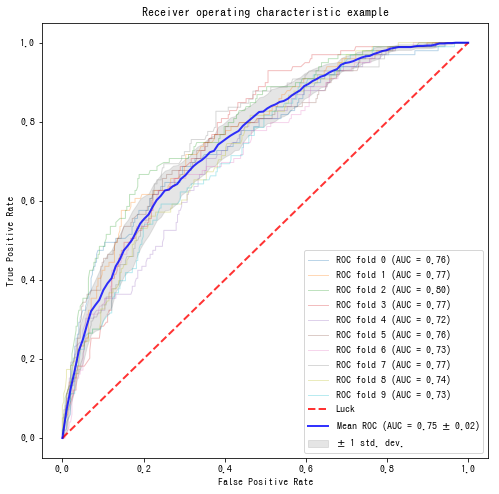

0.7542652698197321


In [252]:
from sklearn.metrics import roc_curve, auc
import numpy as np
from scipy import interp
import matplotlib.pyplot as plt
from itertools import cycle
from pylab import rcParams

from sklearn.model_selection import StratifiedKFold
from sklearn import svm

rcParams['figure.figsize'] = 8,8

random_state = np.random.RandomState(0)

# Run classifier with cross-validation and plot ROC curves
cv = StratifiedKFold(n_splits=10)
classifier = svm.SVC( kernel='rbf', probability=True,
                     random_state=random_state,
                        class_weight='balanced',
                        C =10,gamma=0.0015)

tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)


target_label      = pd.DataFrame(labels_train_resampled,index=list(range(len(labels_train_resampled))))
target_dataset = pd.DataFrame(train_resampled,index=list(range(len(train_resampled))))

i = 0
for train, test in cv.split(train_resampled, labels_train_resampled):
    probas_ = classifier.fit(train_resampled[target_dataset.index.isin(train) ],
                                            target_label[target_label.index.isin(train) ]).predict_proba(train_resampled[target_dataset.index.isin(test) ])
    # Compute ROC curve and area the curve
    fpr, tpr, thresholds = roc_curve(target_label[target_label.index.isin(test) ], probas_[:, 1])
    tprs.append(interp(mean_fpr, fpr, tpr))
    tprs[-1][0] = 0.0
    roc_auc = auc(fpr, tpr)
    aucs.append(roc_auc)
    plt.plot(fpr, tpr, lw=1, alpha=0.3,
             label='ROC fold %d (AUC = %0.2f)' % (i, roc_auc))

    i += 1
    print(str(i) + "：" + str(roc_auc))
    
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
         label='Luck', alpha=.8)

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
plt.plot(mean_fpr, mean_tpr, color='b',
         label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
         lw=2, alpha=.8)

std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
plt.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                 label=r'$\pm$ 1 std. dev.')

plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

print(mean_auc)

+ C =0.3,gamma=0.0004で0.747
+ C =1,gamma=0.01で0.74969
+ C =0.5,gamma=0.05で0.73329
+ C =1,gamma=0.001で0.7519
+ C =2,gamma=0.001で0.75325
+ C =10,gamma=0.001で0.75389

In [253]:
from sklearn.svm import SVC
# SVMのインスタンスを生成
#デフォルトではRBFカーネルで、C=1.0, gamma= 1/特徴数 となっている。
#特徴の数が多いと線形がいいらしい。

model = SVC(kernel='rbf', random_state=1, #rbf
                        class_weight='balanced',
                        C =10,gamma=0.0015) #

# モデルの学習。fit関数で行う。
model.fit(train_resampled, labels_train_resampled)

print('Train score: {:.3f}'.format(model.score(data_train_s_std, label_train_s)))
print('Test score: {:.3f}'.format(model.score(data_test_s_std, label_test_s)))
print('Confusion matrix:\n{}'.format(confusion_matrix(label_test_s, model.predict(data_test_s_std))))

print('Precision score: {:.3f}'.format(precision_score(label_test_s, model.predict(data_test_s_std))))
print('Recall score: {:.3f}'.format(recall_score(label_test_s, model.predict(data_test_s_std))))

print('f1 score: {:.3f}'.format(f1_score(label_test_s, model.predict(data_test_s_std))))
print('AUC score: {:.3f}'.format(roc_auc_score(label_test_s, model.predict(data_test_s_std))))

Train score: 0.672
Test score: 0.677
Confusion matrix:
[[776 378]
 [ 75 173]]
Precision score: 0.314
Recall score: 0.698
f1 score: 0.433
AUC score: 0.685


In [254]:
label_train_s.mean()

0.17599857346647646

In [255]:
label_test_s.mean()

0.1768901569186876